##The Frog Problem<br>
###Blake Rayvid
####Presented by Timandra Harkness and Matt Parker in [*Can you solve The Frog Problem?*](https://www.youtube.com/watch?v=ZLTyX4zL2Fc)

###Statement

Imagine some number of lillypads spanning a river in a line, and a frog at one bank. The frog wants to cross the river. To move forward, it selects one of the lillypads with uniform probability (or the far bank, which we include as an option), hops there, selects a new position closer to its destination, and repeats this process until it eventually reaches the far side.

<strong>*For a given number of lillypads $p$, what is the expected number of jumps for the frog to make it across the river?*</strong>

###Solution

The code in this notebook uses functions from the [``scipy``](https://docs.scipy.org/doc/scipy/reference/), [``itertools``](https://docs.python.org/2/library/itertools.html#itertools.combinations), [``numpy``](https://docs.scipy.org/doc/numpy/) and [``matplotlib``](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot) modules.

In [0]:
from scipy.special import comb # "a choose b," aka binomial coefficient
from itertools import combinations # lists the actual combinations
import numpy as np # matrix operations
from matplotlib import pyplot as pl # plots points

####A few definitions

* Let $p$ be the number of lillypads present. Note that the maximum number of jumps is $p+1$.
* Let $k$ be the number of jumps the frog uses to cross the river, $ 1 \leq k \leq p+1$.
* Let $r={p \choose k-1}$ count the number of ways the frog can cross the river in exactly $k$ jumps.

####Example of a route

The picture below depicts one of the $10$ different ways the frog can cross the river in $3$ steps with $5$ lillypads present.

<center><img src="https://raw.githubusercontent.com/brayvid/FrogProblem/master/FrogExample.png" width=350px></center>

Landing on position $2$ from position $0$ has probability $\frac{1}{6}$, since six positions are initially available to the frog and each is equally likely. In the same way, getting to position $3$ from position $2$ has probability $\frac{1}{4}$, and getting to the far shore from position $3$ has probability $\frac{1}{3}$. 

Thus, the overall probability of taking that particular route as opposed to any other is $\frac{1}{6} \cdot \frac{1}{4}\cdot \frac{1}{3} = \frac{1}{72} \approx 0.014$. We can compute the probability of any route in this way. We expect (and can show) that the probabilities of all routes will add up to $1$.

####List all $r$ possible routes for a given $(p,k)$

The function ``listRoutes(p,k)`` returns all routes for a given $p$ and $k$ as a ``numpy.array`` of size $(r,k+1)$. Each row represents a unique sequence of positions starting at $0$ and ending at $p+1$.

In [0]:
def listRoutes(p, k):
  rows = comb(p, k - 1, 1)
  cols = k + 1
  
  M = [[0 for x in range(cols)] for y in range(rows)]
  
  C = list(combinations(range(1, p + 1), k - 1))
  
  for l in range(k - 1):
    for r in range(rows):
      M[r][l + 1] = C[r][l]
  
  for r in range(rows):
      M[r][cols - 1] = p + 1
      
  return np.array(M)

Following the earlier example, here is the matrix for $p=5$ and $k=3$:

In [0]:
listRoutes(5,3)

array([[0, 1, 2, 6],
       [0, 1, 3, 6],
       [0, 1, 4, 6],
       [0, 1, 5, 6],
       [0, 2, 3, 6],
       [0, 2, 4, 6],
       [0, 2, 5, 6],
       [0, 3, 4, 6],
       [0, 3, 5, 6],
       [0, 4, 5, 6]])

There are indeed ${5 \choose 2} = 10$ unique ways for the frog to cross the river.

####Express the probability of taking a particular route for a given $(p,k)$

Given that at each step along the route all remaining positions have an equal chance of being selected next: if the frog is at position $a$, the probability that the frog will then select the $b^{th}$ position (where $b>a$) equals $(p-a+1)^{-1}$. For example, if there are 3 lillypads and the frog is currently at position $2$, the remaining positions ($3$ and $4$) each have a $\frac{1}{3-2+1}=\frac{1}{2}$ chance of being selected.
<br><br>
To find the probability $P(x)$ that a certain route $x\in\{1,2,...,r\}$ is taken, multiply the probabilities of each successive jump in the sequence:
<br><br>
$$P(x)=\prod_{j=1}^{k} (p-m_{x,j}+1)^{-1}.$$
<br><br>
where $m_{x,j}$ is the element of $M$ in the $x^{th}$ row and $j^{th}$ column, and $M$ is the particular route matrix for the pair $(p,k)$.

####Express the probability of taking any route of length $k$ for a given $p$

Since each route is unique and the list is exhaustive, the probability $P^{\prime}(k)$ that the frog will jump exactly $k$ times to reach the far bank is the sum of the probabilities of each route of length $k$ occuring (i.e. sum the above result over all rows):
<br><br>
$$P^{\prime}(k)=\sum_{i=1}^{r} \prod_{j=1}^{k} (p-m_{i,j}+1)^{-1},$$

The function ``pathLengthProbability(p,k,m)`` implements the above formula, returning $P^{\prime}(k)$ for a given $(p,k)$ and a corresponding matrix $M$:

In [0]:
def pathLengthProbability(p, k, m):
  M = m[:,:-1]
  N = np.full((M.shape[0], k), p + 1)
  minusNM = np.subtract(N, M)
  overNsubM = np.divide(np.ones((M.shape[0], k)), minusNM)
  s = np.sum(np.prod(overNsubM, axis = 1))
  return s

The function ``lengthProb(p,k)`` simply wraps ``pathLengthProbability(p,k,m)`` and ``listRoutes(n,k)`` together for ease of use, returning $P^{\prime}(k)$ for a particular pair $(p,k)$:

In [0]:
def lengthProb(p, k):
  if k <= (p + 1) and k >= 1:
    return pathLengthProbability(p, k, listRoutes(p, k))
  else:
    print("Bad input")
    return 0

####Express the expected number of steps

The expectation of a discrete random variable $X$ is defined as the sum over the sample space $\Omega$:
<br><br>
$$E(X)=\sum_{\omega\in\Omega}x_{\omega}P(x_{\omega}).$$
<br>
Therefore the solution to the problem, the number of steps in which we expect the frog to cross the river for a given $p$, is:
<br><br>
$$E(steps)=\sum_{k=1}^{p+1}k P^{\prime}(k)=\sum_{k=1}^{p+1}k\sum_{i=1}^{r} \prod_{j=1}^{k} (p-m_{i,j}+1)^{-1}.$$
<br><br>

*Note: $M$ will change for each term in the outer sum. A new one must be computed for each value of $k$.*

The function ``expectedSteps(p)`` returns the above quantity given some $p$:

In [0]:
def expectedSteps(p):
  n = p + 1
  s = 0
  for k in range(1, n + 1):
    s += (k * lengthProb(p, k))
  return s

###Examples

####Find the probability that $k=1$ given $p=4$

In [0]:
lengthProb(4,1)

0.2

####Show that the total probability of all routes is $1$ for $p=5$

In [0]:
p = 5
n = p + 1 # max possible jumps
s = 0
for k in range(1, n + 1):
  s += lengthProb(p, k)
print(s)

1.0


####Find the expected number of steps for $p=1$

In [0]:
expectedSteps(1)

1.5

####Plot the expected steps for several $p$

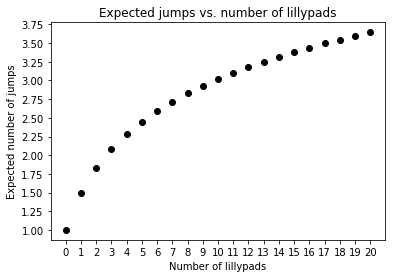

In [0]:
# Values of p to check
lowP = 0
highP = 20

# Plot points
x = range(lowP, highP + 1)
y = []
for p in x:
  y.append(expectedSteps(p))
pl.plot(x,y,'ko')
pl.xlabel('Number of lillypads')
pl.ylabel('Expected number of jumps')
pl.title('Expected jumps vs. number of lillypads')
pl.xticks(np.arange(min(x), max(x) + 1, 1))
pl.yticks(np.arange(min(y), max(y) + 0.25, 0.25))
pl.show()